# Рубежный контроль

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np

## Вариант 1 (Куб)

### Часть 1. Равномерное распределение точек на сфере

Для распределения точек на сфере будем использовать вариант метода Монте-Карло ([Marsaglia, 1972](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177692644)).

In [2]:
ndots = 300

In [3]:
def gen_sphere(n):
    coords = np.array([[],[]])
    s = np.array([])
    
    while coords.shape[1] != n:
        assert coords.shape[1] == s.shape[0]

        tmp_c = np.random.uniform(-1, 1, size=(2, n - coords.shape[1]))
        tmp_s = np.square(tmp_c[0]) + np.square(tmp_c[1])
        tmp_ok = tmp_s < 1

        coords = np.concatenate([coords, np.compress(tmp_ok, tmp_c, axis=1)], axis=1)
        s = np.concatenate([s, tmp_s[tmp_ok]])
        
        z = 1 - 2*s

    m = np.sqrt((1 - np.square(z)) / s)

    x = coords[0] * m / 2
    y = coords[1] * m / 2
    z = z / 2
    
    return np.stack([x, y, z])

#### Пример распределения точек на сфере

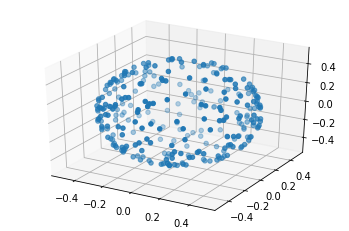

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*gen_sphere(300))
plt.show()

### Часть 2. Распределение точек на кубе

Для равномерного распределения точек на поверхности куба, сделаем распределение на поверхности сферы, вписанной в куб, и спроецируем точки на поверхность куба при помощи продолжения радиус-вектора.

In [5]:
from itertools import product

In [6]:
def create_cube(a):
    return [Plane(*tmp) for tmp in product(range(3), [-abs(a), abs(a)])]

In [7]:
class Plane:
    def __init__(self, axis, const):
        '''
        Parameters
        ==========
        const
            Смещение относительно точки О и размер грани
            
        axis
            Ось смещения относительно точки 0
        '''
        self.axis = axis
        self.const = const
        
    def cross(self, point):
        '''Возвращает точку пересечения радиус-луча и плоскости и коэффициент радиус-вектора'''
        from numpy import dot
        
        e = self.eq()
        t = -e[-1]/dot(e[:3], point.T)
        return point * t, t

    def dots(self):
        '''Возвращает три точки плоскости'''
        from numpy import reshape
        
        return reshape(self.grid().T, (4, 3))[:3]
    
    def eq(self):
        '''Возвращает коэффициенты уравнения плоскости'''
        from numpy import append
        from numpy.linalg import solve
        
        return append(solve(self.dots(), [-1] * 3), 1)
    
    def grid(self):
        '''Возвращает 4 точки, которые задают грань'''
        from numpy import array, full, meshgrid
        
        res = meshgrid(*[[-self.const, self.const]]*2)
        assert res[0].shape == res[1].shape
        
        res.insert(self.axis, full(res[0].shape, self.const))
        return array(res)
    
    def is_on_surf(self, point):
        '''Принадлежит ли точка грани'''
        if point[self.axis] != self.const:
            return False
        
        for i in range(3):
            if i == self.axis:
                continue
            
            if (point[i] < -abs(self.const)) or (point[i] > abs(self.const)):
                return False

        return True

In [8]:
def projection_to_surface(surf, points):
    '''Проекция всех точек на грань'''
    coords, param = np.apply_along_axis(surf.cross, 0, np.array([*points], dtype=np.longdouble))
    coords = np.stack(coords)
    on_surf = np.apply_along_axis(surf.is_on_surf, 0, coords.T)
    
    return coords[on_surf & (param > 0)]

In [9]:
def projection_to_cube(surfaces, points):
    '''Проекция всех точек на все грани'''
    return np.concatenate([projection_to_surface(surf, points) for surf in surfaces])

In [10]:
def gen_cube(n, cube):
    cube_points = projection_to_cube(cube, gen_sphere(n))
    while cube_points.shape[0] != ndots:
        cube_points = np.concatenate([cube_points, projection_to_cube(cube, gen_sphere(n - cube_points.shape[0]))])
    
    return cube_points

#### Пример

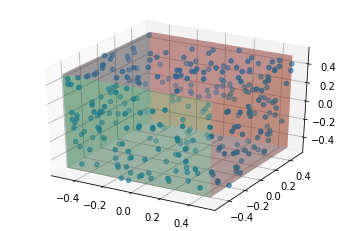

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(*gen_cube(ndots, create_cube(0.5)).T.astype('f'))
for surf in create_cube(0.5):
    ax.plot_surface(*surf.grid(), alpha=0.3)
plt.show()

### Часть 3. Игра

In [12]:
def in_sphere(O, r, point):
    '''Принадлежит ли точка сфере'''
    return ((O - point) ** 2).sum() <= r ** 2

In [13]:
def get_rand_point(surfs):
    '''Возвращает случайную точку на поверхностях'''
    surf = np.random.choice(surfs)
    c = (np.random.random(size=2) * abs(surf.const) * 2 - abs(surf.const)).tolist()
    c.insert(surf.axis, surf.const)
    
    return np.array(c)

In [14]:
def game(n, R, a):
    cube = create_cube(a)
    cube_pts = gen_cube(n, cube)
    p = get_rand_point(cube)
    
    return np.apply_along_axis(lambda o: in_sphere(o, R, p), 0, cube_pts.T).any()

Зададим радиус действия точки

In [15]:
R = 0.1

Зададим сторону куба

In [16]:
a = 0.5

Зададим количество игр

In [17]:
games_count = 100

In [18]:
%%time
cnt = 0
for i in range(games_count):
    if game(ndots, R, a):
        cnt += 1

CPU times: user 29.9 s, sys: 256 ms, total: 30.2 s
Wall time: 33.1 s


In [19]:
print('Цена игры', cnt / games_count)

Цена игры 0.81
